In [1]:
%load_ext pycodestyle_magic
%flake8_on --max_line_length 120

In [2]:
import findspark
findspark.init()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark import SparkContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import RegressionMetrics, RankingMetrics
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr

In [4]:
spark = (SparkSession
         .builder
         .master('local')
         .appName('Movie Recommendations')
         .config('spark.executor.memory', '8g')
         .config('spark.driver.memory', '8g')
         .getOrCreate())

In [5]:
train = spark.read.parquet('data/sample_data_train.parquet')
test = spark.read.parquet('data/sample_data_test.parquet')
movies = spark.read.parquet('data/movie_genre.parquet')

# Baseline model

Recommend the most popular movies to everyone

#### 1) RMSE
Fill predicted rating matrix with average rating

In [6]:
top_movies = (train.groupBy('movieId')
                   .agg({'rating': 'avg', 'userId': 'count'})
                   .withColumnRenamed('movieId', 'predMovieId')
                   .withColumnRenamed('avg(rating)', 'avgRating')
                   .withColumnRenamed('count(userId)', 'reviewCount')
                   .orderBy(['reviewCount', 'avgRating'], ascending=[False, False]))

pred_ratings = (test.join(top_movies, test['movieId'] == top_movies['predMovieId'], how='left')
                    .select(['movieId', 'userId', 'rating', 'avgRating', 'reviewCount']))

rmse = RegressionMetrics(pred_ratings.rdd.map(lambda tup: (tup[2], tup[3])))
rmse.rootMeanSquaredError

0.9560195216413405

#### 2) Precision at 5
Always recommend the five most popular movies to everyone

In [7]:
user_rankings = (test.orderBy(['rating', 'movieId'], ascending=[False, False])
                     .groupBy('userId')
                     .agg(expr('collect_list(movieId) as topMovies')))

top_5_movies = top_movies.limit(5).agg(expr('collect_list(predMovieId) as topMovies')).first()
top_5_movies = top_5_movies.asDict()['topMovies']

pred_rankings = user_rankings.rdd.map(lambda tup: (tup[1], top_5_movies[:len(tup[1])+1]))

metrics = RankingMetrics(pred_rankings)
metrics.precisionAt(5)

0.03625037080984873

# ALS - before hyperparameter tuning
1. RMSE

In [8]:
als = ALS(rank=5, maxIter=5, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')
model = als.fit(train)

metric = 'rmse'
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName=metric, labelCol='rating', predictionCol='prediction')
rmse = evaluator.evaluate(predictions)
print(f'RMSE with test data, before hyperparameter tuning = {rmse}')

RMSE with test data, before hyperparameter tuning = 0.8563250104579093


# ALS - after hyperparameter tuning
1. RMSE
2. RankingMetrics

In [9]:
als = ALS(userCol='userId', itemCol='movieId', ratingCol='rating',
          coldStartStrategy='drop', checkpointInterval=5)

param_grid = (ParamGridBuilder()
              .addGrid(als.rank, [10, 20])
              .addGrid(als.maxIter, [10])
              .addGrid(als.regParam, np.linspace(0.05, 0.3, 10))
              .build())

cross_val = CrossValidator(estimator=als,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=2,
                           collectSubModels=True)

model = cross_val.fit(train)

{'rmse': 0.9196, 'rank': 10, 'maxIter': 10, 'regParam': 0.05}
{'rmse': 0.8867, 'rank': 10, 'maxIter': 10, 'regParam': 0.08}
{'rmse': 0.8718, 'rank': 10, 'maxIter': 10, 'regParam': 0.11}
{'rmse': 0.8669, 'rank': 10, 'maxIter': 10, 'regParam': 0.13}
{'rmse': 0.8685, 'rank': 10, 'maxIter': 10, 'regParam': 0.16}
{'rmse': 0.8745, 'rank': 10, 'maxIter': 10, 'regParam': 0.19}
{'rmse': 0.8834, 'rank': 10, 'maxIter': 10, 'regParam': 0.22}
{'rmse': 0.8939, 'rank': 10, 'maxIter': 10, 'regParam': 0.24}
{'rmse': 0.9053, 'rank': 10, 'maxIter': 10, 'regParam': 0.27}
{'rmse': 0.9171, 'rank': 10, 'maxIter': 10, 'regParam': 0.3}
{'rmse': 0.9258, 'rank': 20, 'maxIter': 10, 'regParam': 0.05}
{'rmse': 0.8883, 'rank': 20, 'maxIter': 10, 'regParam': 0.08}
{'rmse': 0.8732, 'rank': 20, 'maxIter': 10, 'regParam': 0.11}
{'rmse': 0.8687, 'rank': 20, 'maxIter': 10, 'regParam': 0.13}
{'rmse': 0.8706, 'rank': 20, 'maxIter': 10, 'regParam': 0.16}
{'rmse': 0.8766, 'rank': 20, 'maxIter': 10, 'regParam': 0.19}
{'rmse': 

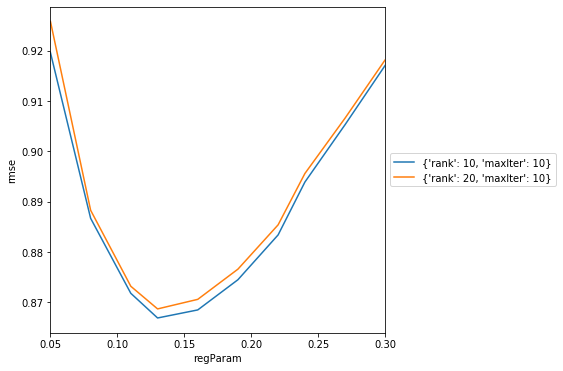

In [10]:
results = []
for avg_metric, param_maps in zip(model.avgMetrics, model.getEstimatorParamMaps()):
    params = {p.name: round(v, 2) for p, v in param_maps.items()}
    result = {metric: round(avg_metric, 4), **params}
    results.append(result)
    print(result)

x_axis = 'regParam'
fig, ax = plt.subplots(figsize=(6, 6))

df = pd.DataFrame(results)
gp_cols = df.columns[~df.columns.str.contains(metric) & (df.columns != x_axis)].tolist()
for _, subset in df.groupby(gp_cols):
    label = str(subset[gp_cols].iloc[0].to_dict())
    (subset.plot(kind='line', x=x_axis, y=metric, label=label, ax=ax)
           .set(xlabel=x_axis, ylabel=metric))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### 1. RMSE

In [11]:
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print(f'RMSE with test data, after hyperparameter tuning = {rmse}')

RMSE with test data, after hyperparameter tuning = 0.8465752992612855


#### 2. RankingMetrics

In [12]:
predictions = model.transform(test)
user_recs = (predictions.orderBy(['rating', 'movieId'], ascending=[False, False])
                        .groupBy('userId')
                        .agg(expr('collect_list(movieId) as predMovies')))
'''
In case there are multiple movies that are tie, pick newer movies

predictions.orderBy(['rating', 'movieId'], ascending=[False, False]).show()
+-------+------+------+----------+
|movieId|userId|rating| timestamp|
+-------+------+------+----------+
|  31696|     1|   4.0|1112485748|
|   7438|     1|   4.0|1112484789|
|   7389|     1|   4.0|1112486045|
|   7046|     1|   4.0|1112485934|
|   4467|     1|   4.0|1112485822|

user_recs.limit(10).show()
+------+--------------------+
|userId|          top_movies|
+------+--------------------+
|     1|[31696, 7438, 738...|
+------+--------------------+
'''

ground_truth = (test.orderBy(['rating', 'movieId'], ascending=[False, False])
                    .groupBy('userId')
                    .agg(expr('collect_list(movieId) as topMovies')))
'''
ground_truth.show()
+------+--------------------+
|userId|          top_movies|
+------+--------------------+
|     2| [242, 469, 70, 260]|
|     3|           [32, 316]|
|     4|[19, 420, 356, 37...|
'''

pred_labels = (user_recs.join(ground_truth, user_recs['userId'] == ground_truth['userId'])
                        .rdd.map(lambda tup: (tup[1], tup[3])))

'''
user_recs.join(ground_truth, user_recs['userId'] == ground_truth['userId']).show()
+------+--------------------+------+--------------------+
|userId|         pred_movies|userId|          top_movies|
+------+--------------------+------+--------------------+
|   148|[469, 182, 543, 2...|   148|[25, 182, 543, 74...|
|   463|[434, 186, 158, 2...|   463|[186, 329, 158, 2...|
|   471|[419, 434, 333, 3...|   471|[434, 266, 333, 3...|
|   496|[339, 352, 514, 3...|   496|[339, 352, 514, 2...|
|   833|[380, 316, 161, 3...|   833|[161, 316, 318, 3...|
|  1088|           [12, 140]|  1088|           [12, 140]|
|  1238|[427, 350, 260, 541]|  1238|[427, 541, 260, 350]|
|  1342|               [168]|  1342|               [168]|
|  1580|           [296, 50]|  1580|           [296, 50]|
|  1591|                [32]|  1591|                [32]|
+------+--------------------+------+--------------------+
'''

metrics = RankingMetrics(pred_labels)
metrics.precisionAt(5)

0.9576386828834175

In [27]:
user_recs = model.bestModel.recommendForAllUsers(10)
user_recs[user_recs['userId'] == 1].toPandas().recommendations.tolist()

[[Row(movieId=5251, rating=5.191382884979248),
  Row(movieId=7758, rating=5.031174182891846),
  Row(movieId=82240, rating=5.014519214630127),
  Row(movieId=59549, rating=4.750442028045654),
  Row(movieId=8986, rating=4.7372870445251465),
  Row(movieId=25963, rating=4.704311847686768),
  Row(movieId=449, rating=4.688320636749268),
  Row(movieId=5896, rating=4.670118808746338),
  Row(movieId=6851, rating=4.660715103149414),
  Row(movieId=51094, rating=4.60836124420166)]]